<a href="https://colab.research.google.com/github/SarahSaeedKhan/DTI/blob/main/attention_UNET_with_drop_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from tensorflow.keras.utils import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

<ipython-input-2-f041a20c67b0>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [ ]:
img_size_target = 256

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Activation

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x

def attention_block(input_tensor, gating_tensor, filters, activation='relu', padding='same'):
    x = concatenate([input_tensor, gating_tensor])
    x = Conv2D(filters, 1, activation=activation, padding=padding)(x)
    x = Conv2D(1, 1, activation='sigmoid', padding=padding)(x)
    return x

def attention_unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.1)(pool1)

    conv2 = conv_block(drop1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.25)(pool2)

    conv3 = conv_block(drop2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.1)(pool3)

    conv4 = conv_block(drop3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.25)(pool4)

    conv5 = conv_block(drop4, 1024)

    # Expansive path
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    attn6 = attention_block(conv4, up6, 512)
    merge6 = concatenate([up6, attn6])
    drop6 = Dropout(0.5)(merge6)
    conv6 = conv_block(drop6, 512)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    attn7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([up7, attn7])
    drop7 = Dropout(0.25)(merge7)
    conv7 = conv_block(drop7, 256)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    attn8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([up8, attn8])
    drop8 = Dropout(0.1)(merge8)
    conv8 = conv_block(drop8, 128)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    attn9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([up9, attn9])
    drop9 = Dropout(0.1)(merge9)
    conv9 = conv_block(drop9, 64)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the Attention U-Net model
model = attention_unet(input_shape=(256, 256, 1))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
import h5py
print("loading data")
#train_path_home='/Users/Madiha/Desktop/Deep_MRI_Unet-master/data/data_set.mat'
train_path_miprg=r'/content/drive/MyDrive/trainingdata_fariha_new.mat'
#test_path_home='/Users/Madiha/Desktop/Deep_MRI_Unet-master/data/test_set.mat'
test_path_miprg=r'/content/drive/MyDrive/testingdata_fariha_new.mat'

data1=h5py.File(train_path_miprg,'r')
arrays={}
for k, v in data1.items():
    arrays[k] = np.transpose(np.array(np.float32(v)), (0, 2, 1))
trX =arrays['input']
trX=np.reshape(trX,(3024,256,256,1))
trY =arrays['label']
trY=np.reshape(trY,(3024,256,256,1))
imgs_train = trX
imgs_mask_train =trY

data2=h5py.File(test_path_miprg,'r')
arrays1={}
for k, v in data2.items():
    arrays1[k] = np.transpose(np.array(np.float32(v)), (0, 2, 1))
trX1 =arrays1['input']
print(trX1.shape)
trX1=np.reshape(trX1,(756,256,256,1))
trY1 =arrays1['label']
trY1=np.reshape(trY1,(756,256,256,1))
test_data = trX1
test_label = trY1

imgs_test=test_data
print("loading data done")

loading data
(756, 256, 256)
loading data done


In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 10
batch_size = 32

history = model.fit(imgs_train, imgs_mask_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/10


ResourceExhaustedError: ignored

In [ ]:
model.save('unet_1000_BNnewAF2.h5')
print('predict test data')
imgs_mask_test = model.predict(imgs_test,batch_size=5, verbose=1)
np.save('AF2_test.npy', imgs_mask_test)

predict test data
152/152 [==============================] - 18s 94ms/step


(756, 256, 256, 1)


(<matplotlib.image.AxesImage at 0x7fd4302ff880>,
 Text(0.5, 1.0, 'Dropout-unet output'))

<Figure size 640x480 with 0 Axes>

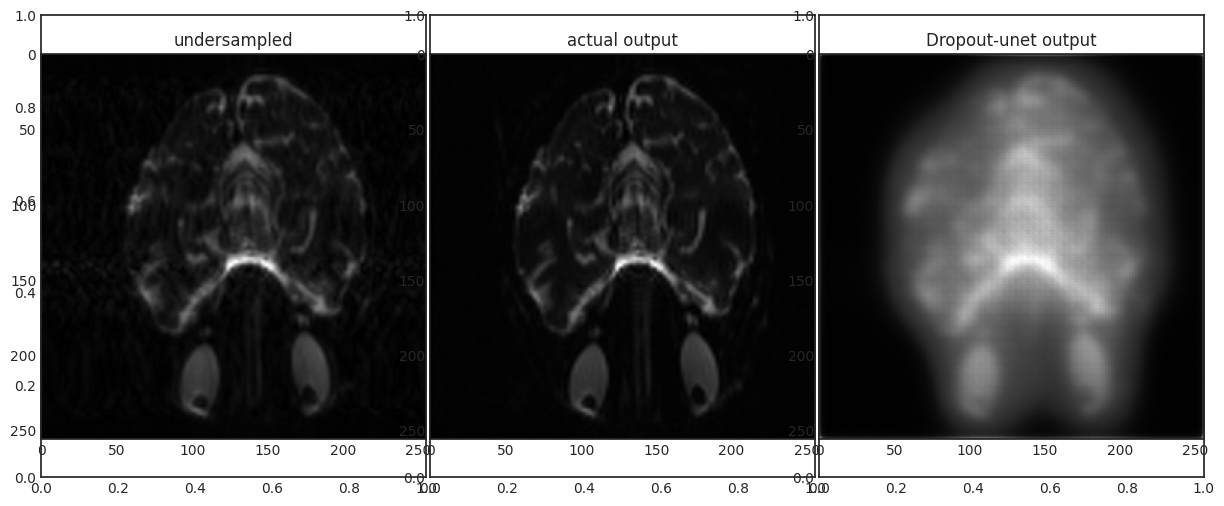

In [ ]:
import matplotlib.pyplot as plt
unet_out={}
unet_out=np.load('AF2_test.npy')
print(unet_out.shape)
image_no=11
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)
ax=fig.add_subplot(1,3,1)
plt.imshow(test_data[image_no,:,:,0],cmap='gray'),plt.title('undersampled')
ax=fig.add_subplot(1,3,2)
plt.imshow(test_label[image_no,:,:,0],cmap='gray'),plt.title('actual output')
ax=fig.add_subplot(1,3,3)
plt.imshow(unet_out[image_no,:,:,0],cmap='gray'),plt.title('Dropout-unet output')

(756, 256, 256, 1)


(<matplotlib.image.AxesImage at 0x7f8feeee70a0>, Text(0.5, 1.0, 'unet output'))

<Figure size 640x480 with 0 Axes>

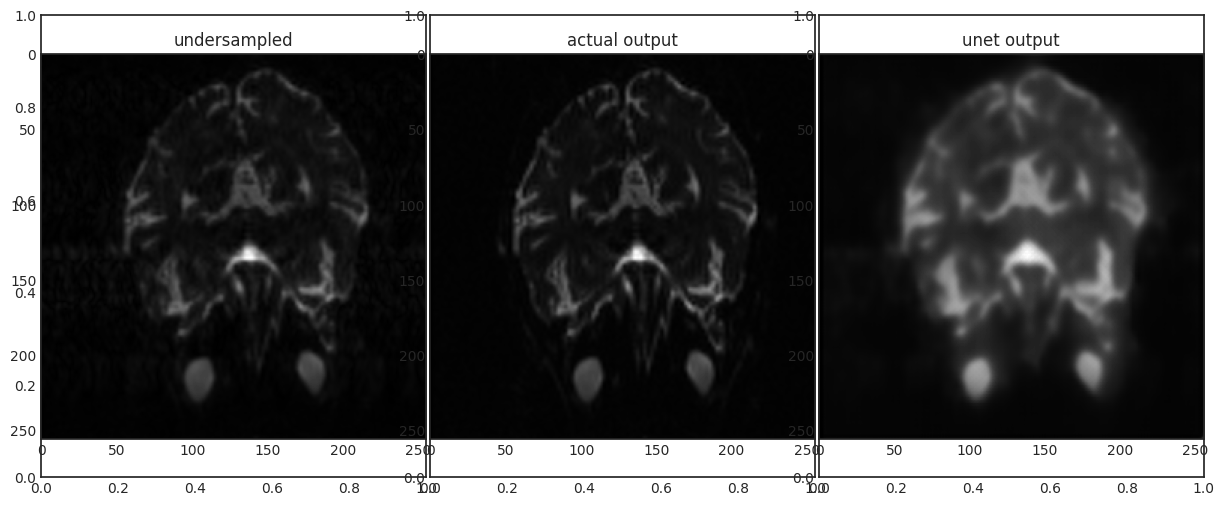

In [ ]:
import matplotlib.pyplot as plt
unet_out={}
unet_out=np.load('AF2_test.npy')
print(unet_out.shape)
image_no=15
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)
ax=fig.add_subplot(1,3,1)
plt.imshow(test_data[image_no,:,:,0],cmap='gray'),plt.title('undersampled')
ax=fig.add_subplot(1,3,2)
plt.imshow(test_label[image_no,:,:,0],cmap='gray'),plt.title('actual output')
ax=fig.add_subplot(1,3,3)
plt.imshow(unet_out[image_no,:,:,0],cmap='gray'),plt.title('unet output')

(756, 256, 256, 1)


(<matplotlib.image.AxesImage at 0x7effd03ca170>, Text(0.5, 1.0, 'unet output'))

<Figure size 640x480 with 0 Axes>

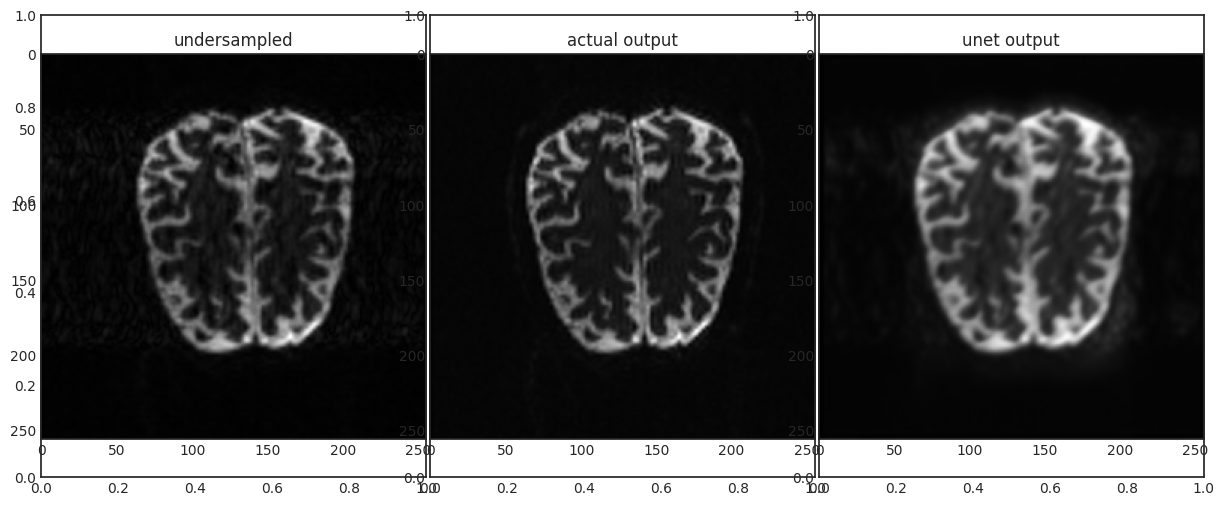

In [ ]:
import matplotlib.pyplot as plt
unet_out={}
unet_out=np.load('AF2_test.npy')
print(unet_out.shape)
image_no=40
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)
ax=fig.add_subplot(1,3,1)
plt.imshow(test_data[image_no,:,:,0],cmap='gray'),plt.title('undersampled')
ax=fig.add_subplot(1,3,2)
plt.imshow(test_label[image_no,:,:,0],cmap='gray'),plt.title('actual output')
ax=fig.add_subplot(1,3,3)
plt.imshow(unet_out[image_no,:,:,0],cmap='gray'),plt.title('unet output')

In [ ]:
#from skimage.measure import compare_ssim as ssim
#from skimage import measure
from skimage.metrics import structural_similarity as ssim
#imageA=unet_corrected_out

imageA=unet_out[image_no,:,:,0]

imageB=test_label[image_no,:,:,0]
#print(imageB.shape)
ssim_value=ssim(imageA,imageB)
print(ssim_value)

0.9022312707660198


In [ ]:
#PSNR
import math

#original = unet_corrected_out
original = unet_out[image_no,:,:,0]

contrast = test_label[image_no,:,:,0]
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(original,contrast)
print(d)

27.00461997953944
